
# Part B Naive Bayes for Discrete Features

## 1. Importing Libraries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Check if GPU is available and set device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


## B1. Dataset Preparation
### 1. Importing Dataset

In [2]:
df = pd.read_csv("adult.csv")
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### 2. Dataset Preprocessing
#### Selecting Relevant Categorical Features


In [3]:
print("Data Types:\n", df.dtypes)

Data Types:
 age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object


In [4]:
# List of categorical columns
cat_cols = [
    "workclass", "education", "marital.status", "occupation",
    "relationship", "race", "sex", "native.country", "income"
]

# Keep only categorical columns, dropped continuous columns
df_cat = df[cat_cols]
df_cat

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
0,?,HS-grad,Widowed,?,Not-in-family,White,Female,United-States,<=50K
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K
2,?,Some-college,Widowed,?,Unmarried,Black,Female,United-States,<=50K
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K
...,...,...,...,...,...,...,...,...,...
32556,Private,Some-college,Never-married,Protective-serv,Not-in-family,White,Male,United-States,<=50K
32557,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States,<=50K
32558,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,>50K
32559,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States,<=50K


### Checking for missing data

In [5]:
print("Number of Missing Values Before Dropping:\n", df_cat.isnull().sum() + (df_cat == "?").sum() ,"\n") # Count missing values and "?" entries

Number of Missing Values Before Dropping:
 workclass         1836
education            0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
native.country     583
income               0
dtype: int64 



### Handling missing data by treating them as seperate Category

In [15]:
adult_df = df_cat.copy() # Create a copy to avoid modifying the original dataframe
adult_df = adult_df.replace(['?', np.nan], 'Missing') # Replace '?' and NaN with 'Missing'

print("Number of Missing Values after handling:\n", adult_df.isnull().sum() + (adult_df == "?").sum() , '\n') 

adult_df.head()


Number of Missing Values after handling:
 workclass         0
education         0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
native.country    0
income            0
dtype: int64 



,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
0,Missing,HS-grad,Widowed,Missing,Not-in-family,White,Female,United-States,<=50K
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K
2,Missing,Some-college,Widowed,Missing,Unmarried,Black,Female,United-States,<=50K
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K


####  Encode categories as integers while maintaining interpretability

In [7]:
# Make a copy of the dataframe
encoded_df = adult_df.copy()

# Dictionary to store mappings for interpretability of encoded values
label_mappings = {} 

# Encode all categorical columns
for col in encoded_df.columns:
    if encoded_df[col].dtype == 'object':  # only encode categorical columns
        le = LabelEncoder() # Initialize LabelEncoder
        encoded_df[col] = le.fit_transform(encoded_df[col]) # Fit encoding and transform the column
        
        # Save the mapping for interpretability
        label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# le.classes_ gives original categories
# le.transform(le.classes_) gives corresponding encoded integer
# zip pairs each category with its integer code in a dictionary
# dict() converts the pairs into a dictionary


print("Sample Encoded DataFrame:\n", encoded_df.head())
# Example: check mapping for 'workclass'
print("\nWorkclass Mapping:", label_mappings["workclass"])
print("\nLabels Mapping:", label_mappings["income"])

Sample Encoded DataFrame:
    workclass  education  marital.status  occupation  relationship  race  sex  \
0          2         11               6           7             1     4    0   
1          4         11               6           3             1     4    0   
2          2         15               6           7             4     2    0   
3          4          5               0           6             4     4    0   
4          4         15               5          10             3     4    0   

   native.country  income  
0              39       0  
1              39       0  
2              39       0  
3              39       0  
4              39       0  

Workclass Mapping: {'Federal-gov': 0, 'Local-gov': 1, 'Missing': 2, 'Never-worked': 3, 'Private': 4, 'Self-emp-inc': 5, 'Self-emp-not-inc': 6, 'State-gov': 7, 'Without-pay': 8}

Labels Mapping: {'<=50K': 0, '>50K': 1}


### Splitting Data 70/15/15

In [8]:
X = encoded_df.drop('income', axis=1)  # All columns except income
Y = encoded_df['income']  # Only income column (Label)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=0)

X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

print(len(X_train), len(X_test), len(X_val))
print(len(Y_train), len(Y_test), len(Y_val))

22792 4884 4885
22792 4884 4885


### class distributions and feature-target relationships

In [9]:
#True class distribution and feature-target relationships
print("Comprehensive class distribution\n")
features = encoded_df.columns.drop('income').tolist()  # All features except target

# 1. Overall label balance (just for context)
label_counts = encoded_df['income'].value_counts() # Count of each class
print("Target Variable Distribution:") 
print(f"  <=50K: {label_counts[0]} samples ({label_counts[0]/len(encoded_df)*100:.1f}%)") # Percentage of each class
print(f"  >50K:  {label_counts[1]} samples ({label_counts[1]/len(encoded_df)*100:.1f}%)")

# 2. Feature distributions within each class
print("\nFeatures distribution within each income class\n")

for feature in features: 
    print(f"\n{feature}:") 
    
    feature_mapping = label_mappings[feature] # Get mapping for current feature to interpret values
    
    # Analyze distribution for <=50K class
    low_income = encoded_df[encoded_df['income'] == 0] # Subset for <=50K
    low_dist = low_income[feature].value_counts(normalize=True).head(3) # Top 3 categories
    
    print("  <=50K earners most common:")
    for val, pct in low_dist.items(): # Iterate over top categories
        cat_name = [k for k, v in feature_mapping.items() if v == val][0] # Reverse lookup to get original category name
        print(f"    {cat_name}: {pct:.1%}") #pct: percentage format
    
    # Analyze distribution for >50K class  
    high_income = encoded_df[encoded_df['income'] == 1] # Subset for >50K
    high_dist = high_income[feature].value_counts(normalize=True).head(3)
    
    print("  >50K earners most common:")
    for val, pct in high_dist.items():
        cat_name = [k for k, v in feature_mapping.items() if v == val][0]
        print(f"    {cat_name}: {pct:.1%}")
    
    # Check if patterns differ significantly
    low_top = set(low_dist.index) # Top categories for <=50K
    high_top = set(high_dist.index) # Top categories for >50K
    difference = len(low_top - high_top) + len(high_top - low_top) # Count unique categories in each class
    
    if difference > 1:
        print(f"  → Different patterns between classes!")
    else:
        print(f"  → Similar patterns between classes")

# 3. Comparative analysis 
print("\nKey differences between classes\n")

interesting_features = ['education', 'occupation', 'marital.status', 'workclass']

for feature in interesting_features: # Focus on most relevant features
    print(f"{feature}:")
    
    # Identify categories that are common in one class but rare in the other
    high_common = set(encoded_df[encoded_df['income'] == 1][feature].value_counts().head(3).index) # Top 3 in >50K
    low_common = set(encoded_df[encoded_df['income'] == 0][feature].value_counts().head(3).index) # Top 3 in <=50K
    
    unique_to_high = high_common - low_common # Categories common in >50K but not in <=50K
    unique_to_low = low_common - high_common # Categories common in <=50K but not in >50K
    
    if unique_to_high:
        print(f"  Unique to >50K: {[list(label_mappings[feature].keys())[list(label_mappings[feature].values()).index(x)] for x in unique_to_high]}")
    if unique_to_low:
        print(f"  Unique to <=50K: {[list(label_mappings[feature].keys())[list(label_mappings[feature].values()).index(x)] for x in unique_to_low]}")
    
    print()

Comprehensive class distribution

Target Variable Distribution:
  <=50K: 24720 samples (75.9%)
  >50K:  7841 samples (24.1%)

Features distribution within each income class


workclass:
  <=50K earners most common:
    Private: 71.7%
    Self-emp-not-inc: 7.4%
    Missing: 6.7%
  >50K earners most common:
    Private: 63.3%
    Self-emp-not-inc: 9.2%
    Self-emp-inc: 7.9%
  → Different patterns between classes!

education:
  <=50K earners most common:
    HS-grad: 35.7%
    Some-college: 23.9%
    Bachelors: 12.7%
  >50K earners most common:
    Bachelors: 28.3%
    HS-grad: 21.4%
    Some-college: 17.7%
  → Similar patterns between classes

marital.status:
  <=50K earners most common:
    Never-married: 41.2%
    Married-civ-spouse: 33.5%
    Divorced: 16.1%
  >50K earners most common:
    Married-civ-spouse: 85.3%
    Never-married: 6.3%
    Divorced: 5.9%
  → Similar patterns between classes

occupation:
  <=50K earners most common:
    Adm-clerical: 13.2%
    Craft-repair: 12.8%
 

## B2. Naive Bayes Implementation

In [10]:
class CategoricalNaiveBayes:
    def __init__(self, alpha=1.0): 
        self.alpha = alpha # Laplace smoothing parameter to avoid zero probabilities
    
    def fit(self, X, y, feature_cards): 
    # Learns the probability patterns from Manual training data
    # feature_cards: list of distinct values per feature
        X = np.asarray(X, dtype=int)
        y = np.asarray(y)
        classes, y_idx = np.unique(y, return_inverse=True)
        self.classes_ = classes
        n_classes = len(classes) # Number of unique classes
        n_samples, n_features = X.shape # Number of samples and features
        class_counts = np.bincount(y_idx, minlength=n_classes) # Count occurrences of each class
        self.class_log_priors_ = np.log((class_counts + self.alpha)/(n_samples + self.alpha*n_classes)) # Class prior with Laplace smoothing
        self.feature_likelihoods_ = []
        
        for j in range(n_features): # counts occurences for each feature for learning likelihoods
            card = feature_cards[j]
            counts = np.zeros((n_classes, card))
            for c in range(n_classes):
                counts[c] = np.bincount(X[y_idx==c, j], minlength=card) # Count occurrences of each category for feature j in class c
            smoothed = (counts + self.alpha) / (counts.sum(axis=1, keepdims=True) + self.alpha*card) #Feature likelihood with Laplace smoothing
            self.feature_likelihoods_.append(np.log(smoothed))
        return self
    
    def _jll(self, X): # joint log likelihood
        X = np.asarray(X, dtype=int) # Ensure input is integer type
        jll = np.tile(self.class_log_priors_, (X.shape[0], 1)) # Start with class log priors
        for j in range(X.shape[1]):
            jll += self.feature_likelihoods_[j][:, X[:, j]].T # Add log likelihoods for feature j
        return jll # Return joint log likelihood matrix
    
    def predict(self, X, return_proba=False): # return probabilities if requested
        jll = self._jll(X)
        idx = np.argmax(jll, axis=1) # Index of max log likelihood
        y_pred = self.classes_[idx] # Predicted classes
        if return_proba:
            m = jll.max(axis=1, keepdims=True) 
            probs = np.exp(jll - m) # Convert log likelihoods to probabilities
            probs /= probs.sum(axis=1, keepdims=True)
            return y_pred, probs # Return both predictions and probabilities
        return y_pred

## B3. Analysis and Evaluation
###  Smoothing Parameter: Test α values [0.1, 0.5, 1.0, 2.0, 5.0]

alpha = 0.1: Validation Accuracy = 0.797
alpha = 0.5: Validation Accuracy = 0.798
alpha = 1.0: Validation Accuracy = 0.797
alpha = 2.0: Validation Accuracy = 0.797
alpha = 5.0: Validation Accuracy = 0.797

Best alpha: 0.5 (Accuracy: 0.798)


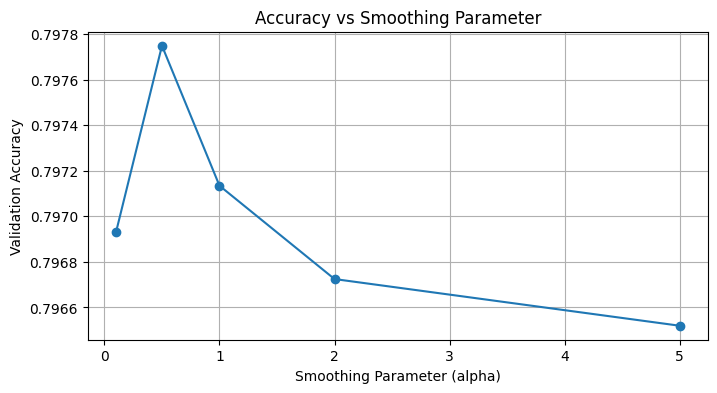


Final test with best alpha alpha=0.5
Test Accuracy: 0.798


In [11]:
X_train_np = X_train.to_numpy()
X_val_np   = X_val.to_numpy() 
X_test_np  = X_test.to_numpy()

Y_train_np = Y_train.to_numpy()   
Y_val_np   = Y_val.to_numpy()
Y_test_np  = Y_test.to_numpy()

# Hyperparameter tuning for alpha (alpha)
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
# alpha is the Laplace smoothing parameter that: 
# - Prevents zero probabilities for unseen feature combinations 
# - Smaller alpha (e.g., 0.1): Less smoothing, more sensitive to training data 
# - Larger alpha (e.g., 5.0): More smoothing, more conservative predictions 
# - alpha=1.0: Default Laplace smoothing
results = []

# Calculate number of categories per feature
feature_cards = [X_train_np[:, j].max() + 1 for j in range(X_train_np.shape[1])]

for alpha in alphas:
    # Train model
    model = CategoricalNaiveBayes(alpha=alpha)
    model.fit(X_train_np, Y_train_np, feature_cards)
    
    # Test on validation set
    val_predictions = model.predict(X_val_np)
    accuracy = np.mean(val_predictions == Y_val_np)
    results.append((alpha, accuracy))
    
    print(f"alpha = {alpha}: Validation Accuracy = {accuracy:.3f}")

# Find best alpha
best_alpha, best_acc = max(results, key=lambda x: x[1])
print(f"\nBest alpha: {best_alpha} (Accuracy: {best_acc:.3f})")

# Quick plot
plt.figure(figsize=(8, 4))
plt.plot([r[0] for r in results], [r[1] for r in results], 'o-')
plt.xlabel('Smoothing Parameter (alpha)')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs Smoothing Parameter')
plt.grid(True)
plt.show()

# Final test with best alpha
print(f"\nFinal test with best alpha alpha={best_alpha}")
final_model = CategoricalNaiveBayes(alpha=best_alpha)
final_model.fit(X_train_np, Y_train_np, feature_cards)

test_predictions = final_model.predict(X_test_np) # Predict on test set
test_accuracy = np.mean(test_predictions == Y_test_np)
print(f"Test Accuracy: {test_accuracy:.3f}")


###  Feature Selection: Analyze impact of different feature subsets

In [12]:
feature_subsets = {
    "All Features": list(range(X_train_np.shape[1])),
    "Demographics Only": [1, 2, 4, 5, 6],   # education, marital.status, relationship, race, sex
    "Work Related": [0, 3, 7], # workclass, occupation, native.country
    "Minimal (workclass + education)": [0, 1] # Adjusted to use existing features
}

subset_results = []

for name, cols in feature_subsets.items():
    # Slice features
    X_train_sub = X_train_np[:, cols]
    X_val_sub   = X_val_np[:, cols]
    X_test_sub  = X_test_np[:, cols]
    
    # Feature cardinalities for this subset
    # Ensure feature_cards_sub is correctly calculated for the sliced subset
    feature_cards_sub = [X_train_sub[:, j].max() + 1 for j in range(X_train_sub.shape[1])] # Number of categories per feature in subset
    
    # Train with best α found earlier
    model = CategoricalNaiveBayes(alpha=best_alpha)
    model.fit(X_train_sub, Y_train_np, feature_cards_sub)
    
    # Validation accuracy
    val_acc = np.mean(model.predict(X_val_sub) == Y_val_np)
    subset_results.append((name, val_acc))
    
    print(f"{name}: Validation Accuracy = {val_acc:.3f}")

# Show results 
print("\nFeature Subset Results")
for name, acc in subset_results:
    print(f"{name:20s}: {acc:.3f}")



All Features: Validation Accuracy = 0.798
Demographics Only: Validation Accuracy = 0.767
Work Related: Validation Accuracy = 0.758
Minimal (workclass + education): Validation Accuracy = 0.776

Feature Subset Results
All Features        : 0.798
Demographics Only   : 0.767
Work Related        : 0.758
Minimal (workclass + education): 0.776


###  Probability Analysis: Examine predicted probabilities distribution


Probability Analysis


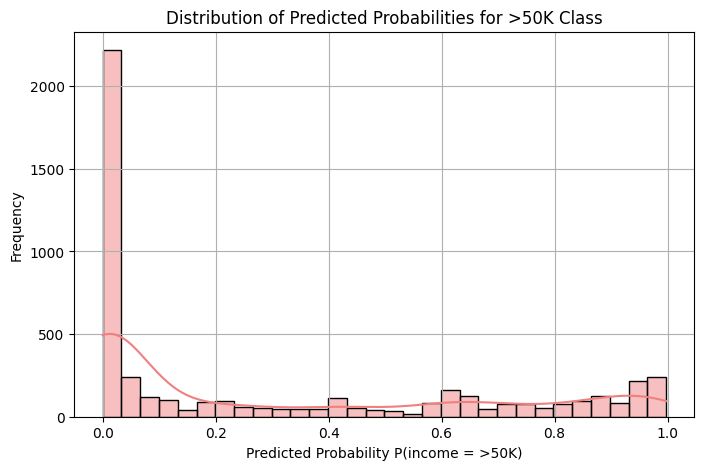

Average confidence for correct predictions: 0.914
Average confidence for incorrect predictions: 0.771
Average probability assigned to the TRUE class for incorrect predictions: 0.229


In [13]:
print("\nProbability Analysis")

# Predict on the test set, requesting probabilities
# Ensure 'final_model' is trained and 'X_test_np', 'Y_test_np' are available
y_pred_test, y_proba_test = final_model.predict(X_test_np, return_proba=True)

# Plotting the distribution of predicted probabilities for the positive class (>50K)
# This gives a good sense of the model's confidence for the target class
plt.figure(figsize=(8, 5))
sns.histplot(y_proba_test[:, 1], bins=30, kde=True, color='lightcoral')
plt.title('Distribution of Predicted Probabilities for >50K Class')
plt.xlabel('Predicted Probability P(income = >50K)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Compare average confidence for correct vs. incorrect predictions
correct_predictions = (y_pred_test == Y_test_np)
incorrect_predictions = ~correct_predictions

# Get the probability assigned to the class that was actually predicted
# This is useful for understanding the model's confidence in its own choices
predicted_class_probs = y_proba_test[np.arange(len(y_pred_test)), y_pred_test]

print(f"Average confidence for correct predictions: {predicted_class_probs[correct_predictions].mean():.3f}")
print(f"Average confidence for incorrect predictions: {predicted_class_probs[incorrect_predictions].mean():.3f}")

# Optional: If you want to see the confidence for the *actual* class for misclassifications
# This shows how low the model's confidence was for the true class when it got it wrong
misclassified_true_probs = y_proba_test[incorrect_predictions, Y_test_np[incorrect_predictions]]
if len(misclassified_true_probs) > 0:
    print(f"Average probability assigned to the TRUE class for incorrect predictions: {misclassified_true_probs.mean():.3f}")
else:
    print("No incorrect predictions to analyze true class probabilities.")



###  Independence Assumption: Discuss violations and their impact


The Naive Bayes classifier is based on the assumption that all features are conditionally independent given the class label. This means that the presence (or absence) of a feature does not affect the presence (or absence) of any other feature when the class label is known.

In real-world datasets, features are often correlated, leading to violations of the independence assumption. For example, in the Adult Income dataset, features such as education and education.num, or occupation and workclass, may exhibit strong dependencies.

###  Performance Comparison: Compare with sklearn's MultinomialNB

1. Manually implemented model:
   Train Accuracy: 0.7923
   Validation Accuracy: 0.7969
   Test Accuracy: 0.7971

2. Sklearn's MultinomialNB:
   Train Accuracy: 0.7488
   Validation Accuracy: 0.7523
   Test Accuracy: 0.7416

3. COMPARISON RESULTS:
   Dataset		Manual NB		Sklearn NB	Difference
   -------------------------------------------------------
   Training		0.7923		0.7488		+0.0434
   Validation		0.7969		0.7523		+0.0446
   Test			0.7971		0.7416		+0.0555

4. DETAILED CLASSIFICATION REPORT (Manual NB vs Sklearn):

   Manual NB - Test Set:
              precision    recall  f1-score   support

       <=50K       0.90      0.82      0.86      3701
        >50K       0.56      0.72      0.63      1183

    accuracy                           0.80      4884
   macro avg       0.73      0.77      0.75      4884
weighted avg       0.82      0.80      0.80      4884


   SKLEARN NB - Test Set:
              precision    recall  f1-score   support

       <=50K       0.82      0.84      0.83 

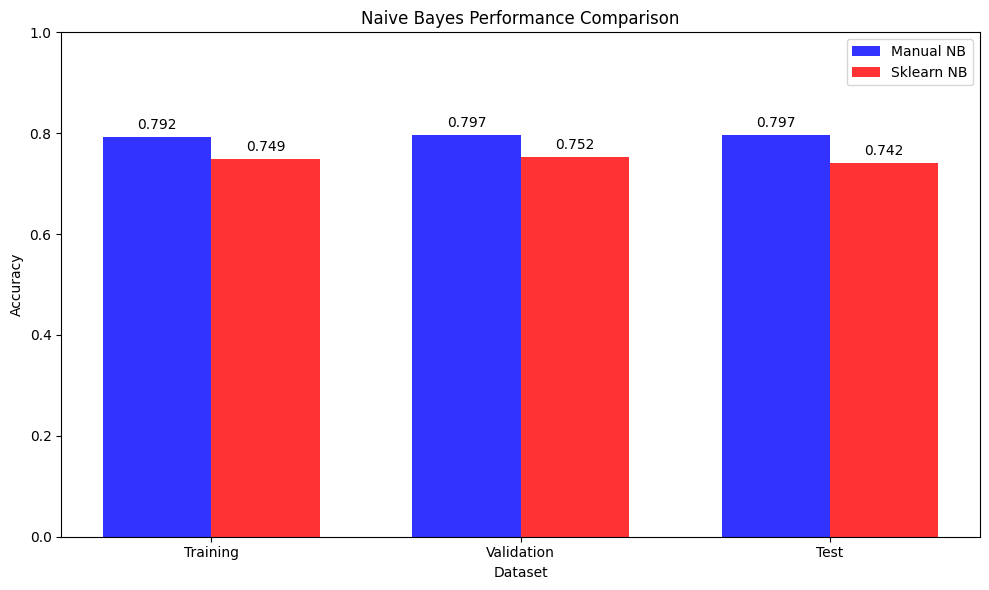

In [14]:
best_alpha = 0.1 #previously determined best alpha

#manual implementation
print("1. Manually implemented model:")
manual_model = CategoricalNaiveBayes(alpha=best_alpha)
manual_model.fit(X_train_np, Y_train_np, feature_cards)

# Predictions
manual_train_pred = manual_model.predict(X_train_np)
manual_val_pred = manual_model.predict(X_val_np)
manual_test_pred = manual_model.predict(X_test_np)

# Accuracies
manual_train_acc = np.mean(manual_train_pred == Y_train_np)
manual_val_acc = np.mean(manual_val_pred == Y_val_np)
manual_test_acc = np.mean(manual_test_pred == Y_test_np)

print(f"   Train Accuracy: {manual_train_acc:.4f}")
print(f"   Validation Accuracy: {manual_val_acc:.4f}")
print(f"   Test Accuracy: {manual_test_acc:.4f}")

#Sklearn implementaion
print("\n2. Sklearn's MultinomialNB:")
sklearn_model = MultinomialNB(alpha=best_alpha)

# Sklearn expects non-negative integers (which we have)
sklearn_model.fit(X_train_np, Y_train_np)

# Predictions
sklearn_train_pred = sklearn_model.predict(X_train_np)
sklearn_val_pred = sklearn_model.predict(X_val_np)
sklearn_test_pred = sklearn_model.predict(X_test_np)

# Accuracies
sklearn_train_acc = accuracy_score(Y_train_np, sklearn_train_pred)
sklearn_val_acc = accuracy_score(Y_val_np, sklearn_val_pred)
sklearn_test_acc = accuracy_score(Y_test_np, sklearn_test_pred)

print(f"   Train Accuracy: {sklearn_train_acc:.4f}")
print(f"   Validation Accuracy: {sklearn_val_acc:.4f}")
print(f"   Test Accuracy: {sklearn_test_acc:.4f}")

# 3. COMPARISON RESULTS
print("\n3. COMPARISON RESULTS:")
print("   Dataset\t\tManual NB\t\tSklearn NB\tDifference")
print("   " + "-" * 55)
print(f"   Training\t\t{manual_train_acc:.4f}\t\t{sklearn_train_acc:.4f}\t\t{manual_train_acc - sklearn_train_acc:+.4f}")
print(f"   Validation\t\t{manual_val_acc:.4f}\t\t{sklearn_val_acc:.4f}\t\t{manual_val_acc - sklearn_val_acc:+.4f}")
print(f"   Test\t\t\t{manual_test_acc:.4f}\t\t{sklearn_test_acc:.4f}\t\t{manual_test_acc - sklearn_test_acc:+.4f}")

# 4. DETAILED CLASSIFICATION REPORT
print("\n4. DETAILED CLASSIFICATION REPORT (Manual NB vs Sklearn):")

print("\n   Manual NB - Test Set:")
print(classification_report(Y_test_np, manual_test_pred, target_names=['<=50K', '>50K']))

print("\n   SKLEARN NB - Test Set:")
print(classification_report(Y_test_np, sklearn_test_pred, target_names=['<=50K', '>50K']))

# 5. VISUAL COMPARISON
plt.figure(figsize=(10, 6))

datasets = ['Training', 'Validation', 'Test']
manual_accs = [manual_train_acc, manual_val_acc, manual_test_acc]
sklearn_accs = [sklearn_train_acc, sklearn_val_acc, sklearn_test_acc]

x_pos = np.arange(len(datasets))
width = 0.35

plt.bar(x_pos - width/2, manual_accs, width, label='Manual NB', alpha=0.8, color='blue')
plt.bar(x_pos + width/2, sklearn_accs, width, label='Sklearn NB', alpha=0.8, color='red')

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Performance Comparison')
plt.xticks(x_pos, datasets)
plt.legend()
plt.ylim(0, 1)

# Add accuracy values on bars
for i, (manual_acc, sklearn_acc) in enumerate(zip(manual_accs, sklearn_accs)):
    plt.text(i - width/2, manual_acc + 0.01, f'{manual_acc:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, sklearn_acc + 0.01, f'{sklearn_acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()